# Supervised Learning
# Project: Finding Donors for *CharityML*

## Getting Started

In this project, we employed several supervised algorithms of our choice to accurately model individuals' income using data collected from the 1994 U.S. Census. we then chose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Our goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
The code cell below loads necessary Python libraries and loads the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# python 3.9.7
# Import libraries necessary for this project
import numpy as np
import pandas as pd # make sure you have the 1.5x version to avoid deprecations that might break the code
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
#import pyplot as plt
import matplotlib.pyplot as plt
# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(10))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


In [2]:
# drop education-num column because its redundant
# displaying correlation matrix is a good way to find redundant columns
data = data.drop(columns=["education-num"])
data.head(10)

,age,workclass,education_level,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, I computed the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

In [3]:
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = data.loc[data['income'] == '>50K'].shape[0]

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k =data.loc[data['income'] == '<=50K'].shape[0]

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k/(n_greater_50k + n_at_most_50k)*100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


**Featureset Exploration**

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num (dropped)**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  int64  
 1   workclass        45222 non-null  object 
 2   education_level  45222 non-null  object 
 3   marital-status   45222 non-null  object 
 4   occupation       45222 non-null  object 
 5   relationship     45222 non-null  object 
 6   race             45222 non-null  object 
 7   sex              45222 non-null  object 
 8   capital-gain     45222 non-null  float64
 9   capital-loss     45222 non-null  float64
 10  hours-per-week   45222 non-null  float64
 11  native-country   45222 non-null  object 
 12  income           45222 non-null  object 
dtypes: float64(3), int64(1), object(9)
memory usage: 4.5+ MB


In [5]:
data.describe()

,age,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,1101.430344,88.595418,40.938017
std,13.217870,7506.430084,404.956092,12.007508
min,17.000000,0.000000,0.000000,1.000000
25%,28.000000,0.000000,0.000000,40.000000
50%,37.000000,0.000000,0.000000,40.000000
75%,47.000000,0.000000,0.000000,45.000000
max,90.000000,99999.000000,4356.000000,99.000000


In [6]:
data.describe(include=['O'])

,workclass,education_level,marital-status,occupation,relationship,race,sex,native-country,income
count,45222,45222,45222,45222,45222,45222,45222,45222,45222
unique,7,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K
freq,33307,14783,21055,6020,18666,38903,30527,41292,34014


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. We were able to manually find and transform these two features due to the small size of the dataset, an alternative to manually trying a variety of transformations is [The Box Cox Transformation](https://opendatascience.com/transforming-skewed-data-for-machine-learning/).

The code cell below plots a histogram of these two features. Note the range of the values present and how they are distributed.

c:\Users\amine\OneDrive\Desktop\AI projects\charityML\salary-prediction\starter\visuals.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


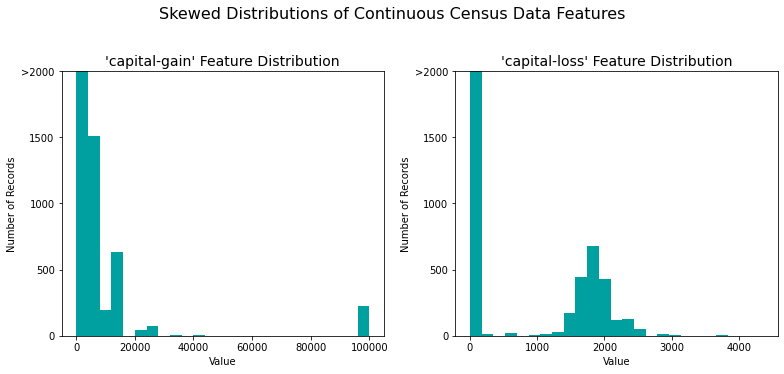

In [7]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

The code cell below performs a transformation on the data and visualizes the results. Again, note the range of values and how they are distributed. 

c:\Users\amine\OneDrive\Desktop\AI projects\charityML\salary-prediction\starter\visuals.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


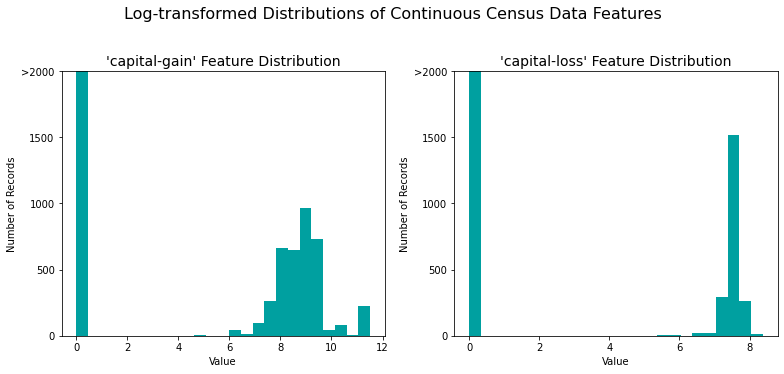

In [8]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

In [9]:
features_log_transformed.describe()

,age,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,0.740759,0.355489,40.938017
std,13.217870,2.466527,1.595914,12.007508
min,17.000000,0.000000,0.000000,1.000000
25%,28.000000,0.000000,0.000000,40.000000
50%,37.000000,0.000000,0.000000,40.000000
75%,47.000000,0.000000,0.000000,45.000000
max,90.000000,11.512925,8.379539,99.000000


### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

The code cell below normalizes each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [10]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age',  'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


In [11]:
features_log_minmax_transform.describe()

,age,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000
mean,0.295177,0.064342,0.042423,0.407531
std,0.181067,0.214240,0.190454,0.122526
min,0.000000,0.000000,0.000000,0.000000
25%,0.150685,0.000000,0.000000,0.397959
50%,0.273973,0.000000,0.000000,0.397959
75%,0.410959,0.000000,0.000000,0.448980
max,1.000000,1.000000,1.000000,1.000000


In [12]:
features_log_minmax_transform.describe(include=['O'])

,workclass,education_level,marital-status,occupation,relationship,race,sex,native-country
count,45222,45222,45222,45222,45222,45222,45222,45222
unique,7,16,7,14,6,5,2,41
top,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
freq,33307,14783,21055,6020,18666,38903,30527,41292


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, I implemented the following:
 - Used [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Converted the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [13]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.map({'<=50K': 0, '>50K': 1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print(encoded)

102 total features after one-hot encoding.
['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ Adm-clerical', 'oc

In [14]:
features_final.head(5)

,age,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.301370,0.667492,0.0,0.397959,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
1,0.452055,0.000000,0.0,0.122449,False,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
2,0.287671,0.000000,0.0,0.397959,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,0.493151,0.000000,0.0,0.397959,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,0.150685,0.000000,0.0,0.397959,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

The code cell below performs this split.

In [15]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0
                                                    # , stratify=income # stratify the data to make sure 
                                                                        # the train and test sets have the same
                                                                        #  proportion of classes as the original dataset
                                                    )

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
**CharityML**, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

**Accuracy** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

**Precision** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

**Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? The code cell below calculates and assings results to `'accuracy'` and `'fscore'` to be used later.

the model's accuracy would be the number of people that generate more than $50,000 devided by total number of people
 
The the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally our base model would be either the results of a previous model or could be based on a research paper upon which we are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place we could start from.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [16]:

TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
# encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# TODO: Calculate accuracy, precision and recall
accuracy = (TP+TN)/(TP+FP+TN+FN)
recall = (TP)/(TP+FN)
precision = (TP)/(TP+FP)

# calculating model accuracy
print("Models accuracy: {:.4f}".format(data['income'].value_counts()['>50K']/len(data['income'])))
# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1.25)*(precision*recall)/((0.25)*precision+recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Models accuracy: 0.2478
Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


IF you are surpised with how bad our naive model is performing, dont worry, we did things the other way around (for chock value!). the right math would be to substract the accuracy and F-score from the number one to get the actual values!

so the correct **accuracy** is: 1-0.2478 = **0.7522**

and the **F-score** : 1-0.2917 = **0.7083**

###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that we chose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Model Application
bellow is a List three of the supervised learning models above that are appropriate for this problem that we will test on the census data. For each model chosen we provided:

- Description of one real-world application in industry where the model can be applied. 
- What are the strengths of the model; and when does it perform well.
- What are the weaknesses of the model; and when does it perform poorly
- What makes this model a good candidate for the problem, given what we know about the data.


### GradientBoostingClassifier
#### 1- real world use case: 
Gradient boosting can be used in the field of learning to rank. The commercial web search engines Yahoo and Yandex use variants of gradient boosting in their machine-learned ranking engines. [wikipedia](https://en.wikipedia.org/wiki/Gradient_boosting#Usage)
think of it like this, we can use gradient boosting to rank poeple who make or less than $50k

#### 2- advantages: 
- Often provides predictive accuracy that cannot be trumped.
- Lots of flexibility - can optimize on different loss functions and provides several hyper parameter tuning options that make the function fit very flexible.
- No data pre-processing required - often works great with categorical and numerical values as is.
- Handles missing data - imputation not required. 
[paperspace](https://www.paperspace.com/blog/gradient-boosting-for-machine-learning)

#### 3- disadvantages:
- Gradient Boosting Models will continue improving to minimize all errors. This can overemphasize outliers and cause overfitting. (high variance)
- Computationally expensive - often require many trees (>1000) which can be time and memory exhaustive.
- The high flexibility results in many parameters that interact and influence heavily the behavior of the approach (number of iterations, tree depth, regularization parameters, etc.). This requires a large grid search during tuning.
- Less interpretative in nature, although this is easily addressed with various tools.
[paperspace](https://www.paperspace.com/blog/gradient-boosting-for-machine-learning)

#### 4- suitability:
Graddient boost is suitable for large datasets with many features and many classes. it can be used in a binary classification problem where the target is a binary value, in our case the target is an income value and we can use the model to predict if the income is greater than or less than 50k.

### RandomForestClassifier 
#### 1- real world use case: 
Random forest classifier can be used to detect separate in a dataset. It can be used to classify observations into different categories, like income in our case. it can detect customers who are more likely to pay debt or not. 
#### 2- advantages: 
- It can handle binary features, categorical features, and numerical features. There is very little pre-processing that needs to be done. The data does not need to be rescaled or transformed.
- They are parallelizable, meaning that we can split the process to multiple machines to run.
- Great with High dimensionality
- Quick Prediction/Training Speed
- Handles Unbalanced Data
[towarddatascience.com](https://towardsdatascience.com/why-random-forest-is-my-favorite-machine-learning-model-b97651fa3706), 

#### 3- disadvantages:
- Model interpretability: Random forest models are not all that interpretable; they are like black boxes.
- For very large data sets, the size of the trees can take up a lot of memory.
- It can tend to overfit, so you should tune the hyperparameters.
[towarddatascience.com](https://towardsdatascience.com/why-random-forest-is-my-favorite-machine-learning-model-b97651fa3706)
#### 4- suitability:
Random forest is a great when it comes to classification problems. with a large number of features and an unbalanced dataset, different data fields, and a low training time, it can be a great model.

### HistGradientBoostingClassifier
#### 1- real world use case: 
same use case as gradddientBoost but for larger datasets (>10k lines)
#### 2- advantages: 
- This estimator has native support for missing values (NaNs). 
- speed many times greater than exact gradient boosting
- It is very fast at classifying unknown records.	
- parallelizable and well optimized training performance
#### 3- disadvantages:
- only includes a handful of hyperparameters and two loss functions.
- relatively new
- experimental phase

#### 4- suitability:
HistGradientBoostingClassifier is an effective model for high dimensional large datasets. drastically faster training time is excellent for experimentation with hyperparamaters tuning.


### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model we've chosen, it's important that we create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Our implementation here will be used in the following section.
In the code block below, we will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that we set the `beta` parameter

In [17]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
# 
from  sklearn.metrics import fbeta_score, accuracy_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta = 0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, we will need to implement the following:
- Import the three supervised learning models we've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model we use, if provided.
  - **Note:** We used the default settings for each model — we will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms we chose, the following implementation may take some time to run!

c:\Users\amine\anaconda3\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


RandomForestClassifier trained on 361 samples.


RandomForestClassifier trained on 904 samples.
RandomForestClassifier trained on 36177 samples.
HistGradientBoostingClassifier trained on 361 samples.
HistGradientBoostingClassifier trained on 904 samples.
HistGradientBoostingClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 904 samples.
GradientBoostingClassifier trained on 36177 samples.


c:\Users\amine\OneDrive\Desktop\AI projects\charityML\salary-prediction\starter\visuals.py:121: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


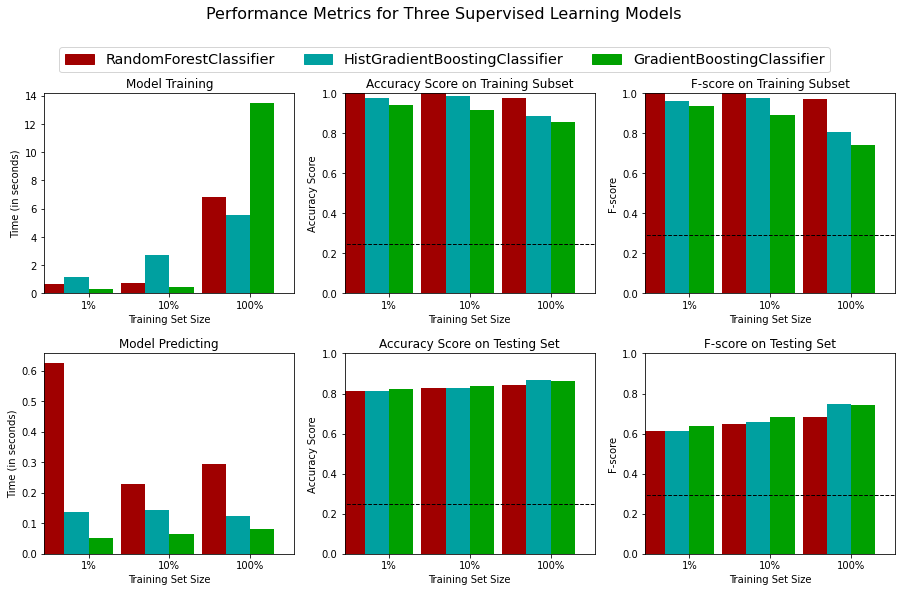

In [18]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

# TODO: Initialize the three models
clf_A = RandomForestClassifier(random_state = 42, n_jobs = -1)
clf_B = HistGradientBoostingClassifier(random_state =42)
clf_C = GradientBoostingClassifier(random_state = 42)


# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = int(len(y_train))
samples_10 = int(len(y_test)/10)
samples_1 = int(len(y_train)/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)


In [19]:

df_RFC = pd.DataFrame(results['RandomForestClassifier'])
df_LR  = pd.DataFrame(results['HistGradientBoostingClassifier'])
df_GB  = pd.DataFrame(results['GradientBoostingClassifier'])
# concatenate all the data frames into a single data frame
df_all = pd.concat([df_RFC, df_LR, df_GB],keys =['RandomForestClassifier', 'GradientBoostingClassifier', 'HistGradientBoostingClassifier'] ,axis = 1)
# rename the columns of the data frame
df_all.columns 
# plot the data frame


MultiIndex([(        'RandomForestClassifier', 0),
            (        'RandomForestClassifier', 1),
            (        'RandomForestClassifier', 2),
            (    'GradientBoostingClassifier', 0),
            (    'GradientBoostingClassifier', 1),
            (    'GradientBoostingClassifier', 2),
            ('HistGradientBoostingClassifier', 0),
            ('HistGradientBoostingClassifier', 1),
            ('HistGradientBoostingClassifier', 2)],
           )

In [20]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income,  test_size = 0.4, random_state = 0)
# split test set into test and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 0)


clf_A = RandomForestClassifier(random_state = 0)
clf_B = GradientBoostingClassifier(random_state = 0)

n_estimators = 50
clf_C = HistGradientBoostingClassifier(random_state = 0)


# create a list with all the classifiers 
clfs = [clf_A, clf_B, clf_C]


# train the classifiers with validation set
results_val = {}
for clf in clfs:
    clf_name = clf.__class__.__name__
    print('=' * 80)
    print(clf_name)
    results_val[clf_name] = {}
    results_val[clf_name][i] = train_predict(clf, samples_100, X_train, y_train, X_val, y_val)


RandomForestClassifier


RandomForestClassifier trained on 36177 samples.
GradientBoostingClassifier
GradientBoostingClassifier trained on 36177 samples.
HistGradientBoostingClassifier
HistGradientBoostingClassifier trained on 36177 samples.


In [21]:
# conver results_val to data frame
df_val = pd.concat([pd.DataFrame(results_val[key]) for key in results_val.keys()],keys = ['RandomForestClassifier',  'GradientBoostingClassifier', 'hist'] ,axis=1)
df_val
    

,RandomForestClassifier,GradientBoostingClassifier,hist
,2,2,2
acc_test,0.844887,0.861581,0.872858
acc_train,0.973333,0.876667,0.880000
f_test,0.682393,0.732793,0.750340
f_train,0.956790,0.753676,0.743671
pred_time,0.437806,0.045974,0.301000
train_time,11.206982,9.408162,6.146421


<Axes: title={'center': 'f_train of each learner'}>

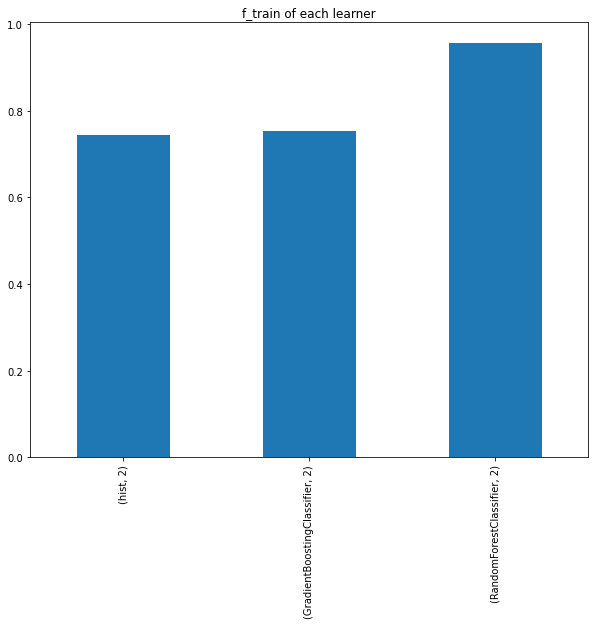

In [22]:
# plot f_train of each learner
(df_val.loc['f_train'].sort_values()).plot(kind = 'bar', title = 'f_train of each learner', figsize = (10,8))

<Axes: title={'center': 'f_test of each learner'}>

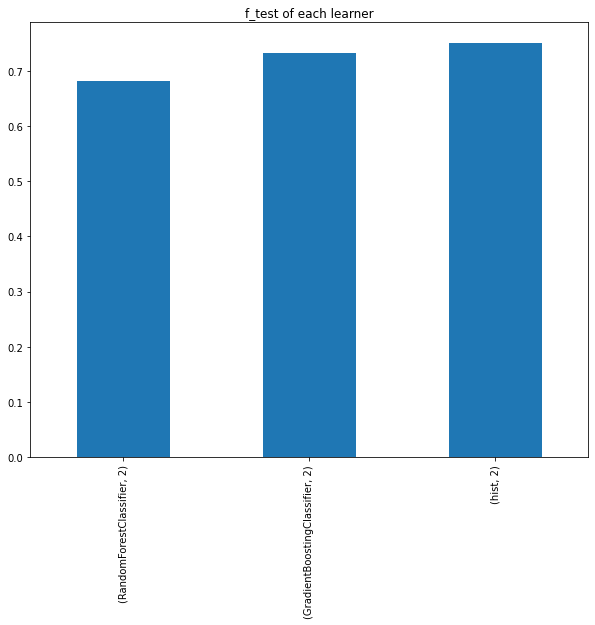

In [23]:
# plot f_test of each learner
(df_val.loc['f_test'].sort_values()).plot(kind = 'bar', title = 'f_test of each learner', figsize = (10,8))

In [33]:
from sklearn.model_selection import cross_val_score,cross_validate
# import repeated stratified k fold cross validation
from sklearn.model_selection import RepeatedStratifiedKFold
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
# evaluate the model and collect the scores
scoring = ['precision', 'recall']
cross_val_scores = {}
for clf in clfs:
    clf_name = clf.__class__.__name__
    print('=' * 80)
    print(clf_name)
    cross_val_scores[clf_name] = cross_validate(clf, features_final, 
                                                    income, cv=cv, scoring=scoring, n_jobs=-1)
                                                    
    print("precision_macro: %0.2f (+/- %0.2f)" % (cross_val_scores[clf_name]['test_precision'].mean(), cross_val_scores[clf_name]['test_precision'].std() * 2))
    print("recall_macro: %0.2f (+/- %0.2f)" % (cross_val_scores[clf_name]['test_recall'].mean(), cross_val_scores[clf_name]['test_recall'].std() * 2))
    print('fit time : %0.2f' % (cross_val_scores[clf_name]['fit_time'].sum()/60))

RandomForestClassifier


precision_macro: 0.71 (+/- 0.02)
recall_macro: 0.62 (+/- 0.02)
fit time : 9.18
GradientBoostingClassifier
precision_macro: 0.80 (+/- 0.02)
recall_macro: 0.59 (+/- 0.02)
fit time : 7.74
HistGradientBoostingClassifier
precision_macro: 0.78 (+/- 0.02)
recall_macro: 0.66 (+/- 0.03)
fit time : 3.70


In [34]:
cross_val_scores_test = {}
for clf in clfs:
    clf_name = clf.__class__.__name__
    print('=' * 80)
    print(clf_name)
    cross_val_scores_test[clf_name] = cross_validate(clf, X_test, y_test, cv=cv, scoring=scoring,  n_jobs=-1)
    print("time: " + str(cross_val_scores_test[clf_name]['fit_time'].sum()/60))
    

RandomForestClassifier


time: 3.1092935681343077
GradientBoostingClassifier
time: 3.4838680346806843
HistGradientBoostingClassifier
time: 4.401819956302643


In [35]:
cross_val_scores_df = pd.DataFrame(cross_val_scores)
cross_val_scores_df

,RandomForestClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier
fit_time,"[18.846632719039917, 19.01863718032837, 18.892...","[19.523082971572876, 19.34907603263855, 19.435...","[10.347354412078857, 10.207315444946289, 10.31..."
score_time,"[0.6300017833709717, 0.6400043964385986, 0.647...","[0.12699365615844727, 0.10000014305114746, 0.1...","[0.28600335121154785, 0.26299023628234863, 0.2..."
test_precision,"[0.706034038164002, 0.6886138613861386, 0.7077...","[0.7959434542102028, 0.7893491124260354, 0.796...","[0.7907106883044208, 0.7613293051359517, 0.787..."
test_recall,"[0.6106155218554862, 0.6204281891168599, 0.630...","[0.5776092774308653, 0.5950044603033007, 0.589...","[0.6302408563782337, 0.6743978590544157, 0.666..."


In [36]:
# transpose the dataframes to get the results in the right order
cross_val_scores_df = cross_val_scores_df.T
# convert the cross_val_scores_df to a dataframe with np.array
cross_val_scores_df


,fit_time,score_time,test_precision,test_recall
RandomForestClassifier,"[18.846632719039917, 19.01863718032837, 18.892...","[0.6300017833709717, 0.6400043964385986, 0.647...","[0.706034038164002, 0.6886138613861386, 0.7077...","[0.6106155218554862, 0.6204281891168599, 0.630..."
GradientBoostingClassifier,"[19.523082971572876, 19.34907603263855, 19.435...","[0.12699365615844727, 0.10000014305114746, 0.1...","[0.7959434542102028, 0.7893491124260354, 0.796...","[0.5776092774308653, 0.5950044603033007, 0.589..."
HistGradientBoostingClassifier,"[10.347354412078857, 10.207315444946289, 10.31...","[0.28600335121154785, 0.26299023628234863, 0.2...","[0.7907106883044208, 0.7613293051359517, 0.787...","[0.6302408563782337, 0.6743978590544157, 0.666..."


In [37]:
# calculate fbeta score for each classifier
beta = .5
cross_val_scores_df['fbeta'] = (1 + beta**2) * cross_val_scores_df['test_recall'] * cross_val_scores_df['test_precision'] / (beta**2 * cross_val_scores_df['test_recall'] + cross_val_scores_df['test_precision'])
cross_val_scores_df

,fit_time,score_time,test_precision,test_recall,fbeta
RandomForestClassifier,"[18.846632719039917, 19.01863718032837, 18.892...","[0.6300017833709717, 0.6400043964385986, 0.647...","[0.706034038164002, 0.6886138613861386, 0.7077...","[0.6106155218554862, 0.6204281891168599, 0.630...","[0.6275786192353534, 0.6329632326174007, 0.644..."
GradientBoostingClassifier,"[19.523082971572876, 19.34907603263855, 19.435...","[0.12699365615844727, 0.10000014305114746, 0.1...","[0.7959434542102028, 0.7893491124260354, 0.796...","[0.5776092774308653, 0.5950044603033007, 0.589...","[0.61113732892874, 0.625820979545881, 0.621822..."
HistGradientBoostingClassifier,"[10.347354412078857, 10.207315444946289, 10.31...","[0.28600335121154785, 0.26299023628234863, 0.2...","[0.7907106883044208, 0.7613293051359517, 0.787...","[0.6302408563782337, 0.6743978590544157, 0.666...","[0.6569037656903766, 0.6901588460836224, 0.687..."


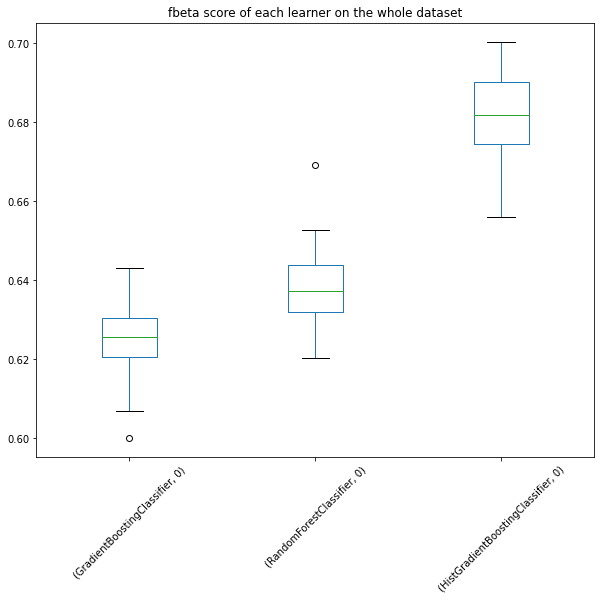

In [42]:
# plot whisker boxes to find the model who would more opten than not perform the best
import seaborn as sns
import matplotlib.pyplot as plt

fbeta_df = pd.concat([pd.DataFrame(cross_val_scores_df['fbeta'][field]) for field in cross_val_scores_df.index], keys=cross_val_scores_df.index, axis=1)

#  df.reindex(df.mean().sort_values().index, axis=1)
fbeta_df = fbeta_df.reindex(fbeta_df.quantile(.8).sort_values().index, axis=1)


plt.figure(figsize=(10,8))
fbeta_df.boxplot(grid=False)
plt.title('fbeta score of each learner on the test dataset (higher is better)')
plt.xticks(rotation=45)
plt.show()
# rotate xlabels


In [39]:
# create dataframe from the results
cross_val_scores_test_df = pd.DataFrame(cross_val_scores_test)
# transpose the test scores dataframe to get the results in the right order
cross_val_scores_test_df = cross_val_scores_test_df.T
# convert the cross_val_scores_df to a dataframe with np.array
cross_val_scores_test_df

,fit_time,score_time,test_precision,test_recall
RandomForestClassifier,"[9.436400651931763, 9.567393064498901, 9.72247...","[0.37005114555358887, 0.24399924278259277, 0.2...","[0.7235142118863049, 0.6790450928381963, 0.717...","[0.6306306306306306, 0.5765765765765766, 0.593..."
GradientBoostingClassifier,"[10.276749610900879, 10.942858457565308, 10.64...","[0.08100152015686035, 0.15000295639038086, 0.1...","[0.7804878048780488, 0.7791798107255521, 0.815...","[0.5765765765765766, 0.5563063063063063, 0.566..."
HistGradientBoostingClassifier,"[11.208142518997192, 11.494635343551636, 11.53...","[0.256458044052124, 0.12703919410705566, 0.127...","[0.7681940700808625, 0.7569060773480663, 0.790...","[0.6418918918918919, 0.6171171171171171, 0.651..."


In [40]:
# calculate fbeta score for each classifier
beta = .5
cross_val_scores_test_df['fbeta'] = (1 + beta**2) * cross_val_scores_test_df['test_recall'] * cross_val_scores_test_df['test_precision'] / (beta**2 * cross_val_scores_test_df['test_recall'] + cross_val_scores_test_df['test_precision'])
cross_val_scores_test_df

,fit_time,score_time,test_precision,test_recall,fbeta
RandomForestClassifier,"[9.436400651931763, 9.567393064498901, 9.72247...","[0.37005114555358887, 0.24399924278259277, 0.2...","[0.7235142118863049, 0.6790450928381963, 0.717...","[0.6306306306306306, 0.5765765765765766, 0.593...","[0.6472491909385114, 0.594519275429633, 0.6145..."
GradientBoostingClassifier,"[10.276749610900879, 10.942858457565308, 10.64...","[0.08100152015686035, 0.15000295639038086, 0.1...","[0.7804878048780488, 0.7791798107255521, 0.815...","[0.5765765765765766, 0.5563063063063063, 0.566...","[0.6083650190114068, 0.5900621118012422, 0.603..."
HistGradientBoostingClassifier,"[11.208142518997192, 11.494635343551636, 11.53...","[0.256458044052124, 0.12703919410705566, 0.127...","[0.7681940700808625, 0.7569060773480663, 0.790...","[0.6418918918918919, 0.6171171171171171, 0.651...","[0.663716814159292, 0.6407857811038354, 0.6753..."


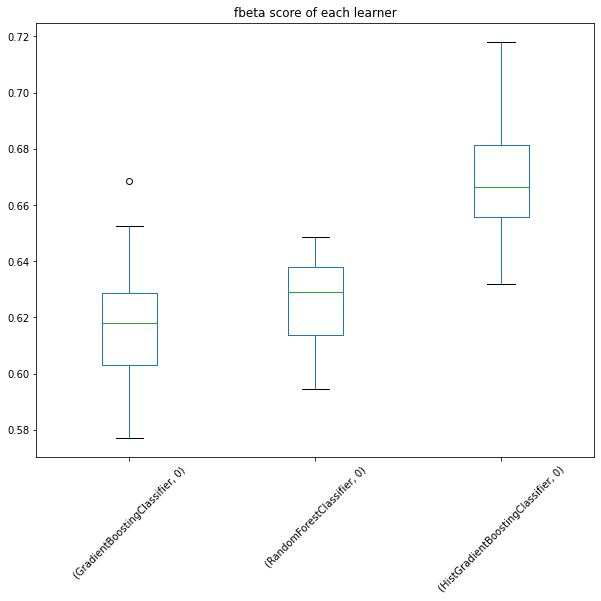

In [43]:
fbeta_test_df =  pd.concat([pd.DataFrame(cross_val_scores_test_df['fbeta'][field]) for field in cross_val_scores_test_df.index], keys=cross_val_scores_test_df.index, axis=1)
# reindex by mean values for each classifier
fbeta_test_df = fbeta_test_df.reindex(fbeta_test_df.quantile(.9).sort_values().index, axis=1)

plt.figure(figsize=(10,8))
fbeta_test_df.boxplot(grid=False)

plt.title('fbeta score of each learner on the validation set (Higher is better)'
plt.xticks(rotation=45)
plt.show()


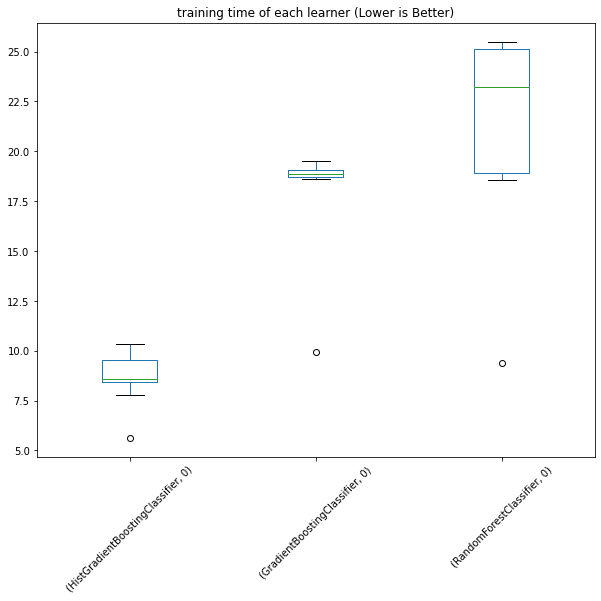

In [45]:
# plot whisker boxes of fit time
fit_time_df = pd.concat([pd.DataFrame(cross_val_scores_df['fit_time'][field]) for field in cross_val_scores_df.index], keys=cross_val_scores_df.index, axis=1)
fit_time_df = fit_time_df.reindex(fit_time_df.quantile(.9).sort_values().index, axis=1)

plt.figure(figsize=(10,8))
fit_time_df.boxplot(grid=False)
plt.title('training time of each learner (Lower is Better)')
plt.xticks(rotation=45)
plt.show()

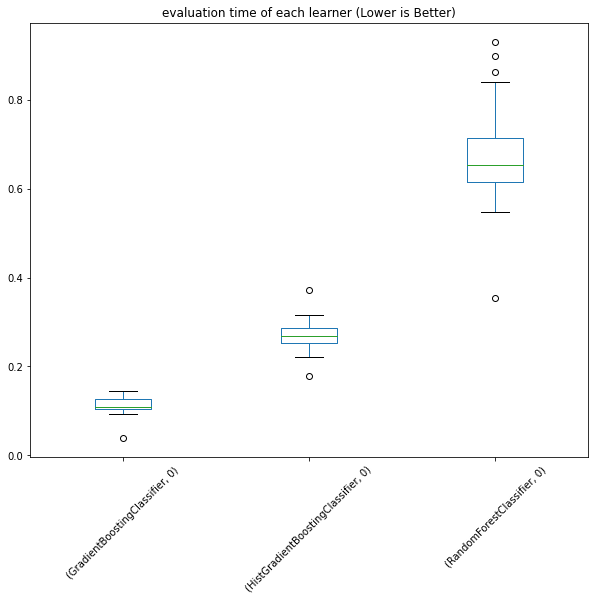

In [47]:
#plot whisker boxes of score time
score_time_df = pd.concat([pd.DataFrame(cross_val_scores_df['score_time'][field]) for field in cross_val_scores_df.index], keys=cross_val_scores_df.index, axis=1)
score_time_df = score_time_df.reindex(score_time_df.quantile(.9).sort_values().index, axis=1)

plt.figure(figsize=(10,8))
score_time_df.boxplot(grid=False)
plt.title('evaluation time of each learner (Lower is Better)')
plt.xticks(rotation=45)
plt.show()


----
## Improving Results
In this final section, we will choose from the three supervised learning models the *best* model to use on the student data. We will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

**Answer: **
The model with the highest F score is the Hist Gradient Boosting Classifier. This model is the best model to use for this task. The F score is more likely to be the highest, which is a good score. And always the fastest in training and evaluating. plus the models is perfect for large tabular data, The model is fast and accurate and can be used for this task.

### Describing the Model in Layman's Terms

* We will, in one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. We are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. With avoiding the use of advanced mathematical jargon, such as describing equations.

Boosting refers to a class of ensemble learning algorithms that add tree models to an ensemble sequentially. Each tree model added to the ensemble attempts to correct the prediction errors made by the tree models already present in the ensemble. its like having field experts giving seqential opinions on a matter and the final result is the consensus.

Gradient boosting is a generalization of boosting algorithms like AdaBoost to a statistical framework that treats the training process as an additive model and allows arbitrary loss functions to be used, greatly improving the capability of the technique (the field experts would point out mistakes of previous experts to correct their way of thinking and perform a better judgement in the next operation). As such, gradient boosting ensembles are the go-to technique for most structured (e.g. tabular data) predictive modeling tasks.

### Implementation: Model Tuning
When fine tuning the chosen model. We use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. we will need to use the entire training set for this. In the code cell below, we will implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier we've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state we set before.
- Create a dictionary of parameters we wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** We avoid tuning the `max_features` parameter of our learner if that parameter is available!
- We use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [ ]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
# TODO: Initialize the classifier
clf = HistGradientBoostingClassifier(random_state=42)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {  
                'early_stopping': [False], 
                'learning_rate': [.18,0.2, 0.15],
                'max_leaf_nodes': [19,23,13,15,18],
                'l2_regularization': [.11,0.09,.07,.13],
                'min_samples_leaf': [5,10,15,20],
                'scoring' : ['f1'],
                'validation_fraction': [0.2],
                'max_iter': [2500]
                }  

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer,n_jobs=-1,cv=3)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(features_final, income)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8672
F-score on testing data: 0.7439

Optimized Model
------
Final accuracy score on the testing data: 0.9176
Final F-score on the testing data: 0.8480


###  Final Model Evaluation

* What is our optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from our optimized model compare to the naive predictor benchmarks we found earlier in **Question 1**?_  


#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |     0.8672        |    0.9176       |
| F-score        |     0.7439        |    0.8480       |



The results from the optimized model are better than the naive predictor benchmarks. an increase of about 15% in F-score and 16% in accuracy.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

We chose a scikit-learn classifier (HistGradientBoostingClassifier) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell we fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Extracting Feature Importance

In the code cell below, We will implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

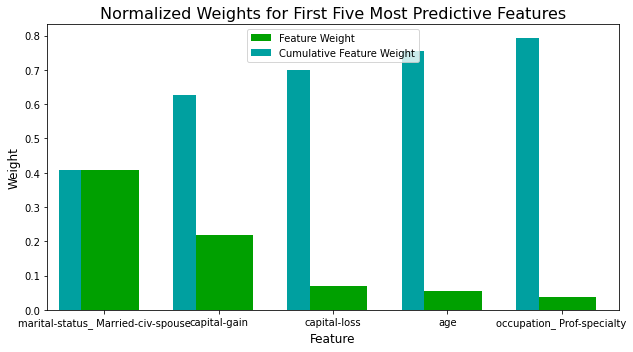

In [ ]:
# TODO: Import a supervised learning model that has 'feature_importances_'

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances,X_train, y_train)

The most important feature is married-civ-souse, followed by capital gain, capital loss, and Age.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model we found earlier, and train it on the same training set *with only the top five important features*. 

In [ ]:
# Import functionality for cloning a model
from sklearn.base import clone
#split the dataset 
X_train, X_test, y_train, y_test = train_test_split(features_final, income, test_size = 0.2, random_state = 0)
# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.9203
F-score on testing data: 0.8542

Final Model trained on reduced data
------
Accuracy on testing data: 0.8434
F-score on testing data: 0.7155


### Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
    * the reduced dataset has a lower F-score and accuracy score than the full data set settking at around 8-14 percent reduction.
* If training time was a factor, would we consider using the reduced data as our training set?
    * since the new data set is much smaller, yet the model still performs well (-3% from full data with the unpotimized model), it is feasable to use the reduced data and optimize the model.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.